In [2]:
import numpy as np
import math as math 
import pandas as pd
import matplotlib as plt
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
import calendar
# from datetime import datetime

from astral.sun import sun
from astral import LocationInfo

import warnings

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

from shapely.geometry.point import Point
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_regression
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import mapclassify

## Read input files

In [3]:
df_all = pd.read_csv('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/NYPD_Complaint_All_Clean.csv', sep=",")

subway = pd.read_csv('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/SUBWAY_ENTRANCE.csv')

nynta = pd.read_csv ('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/nynta.csv')

nyc_pop = pd.read_csv('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv')
nyc_pop2010 = nyc_pop[nyc_pop['Year'] == 2010]

holidays = pd.read_csv ('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/US_Holiday_Dates.csv')

## Add PAI Index

In [4]:
#--- Add PAI Index
#========================  

ofns_list = ['PETIT LARCENY', 'GRAND LARCENY', 'BURGLARY', 'INTOXICATED & IMPAIRED DRIVING', 'DANGEROUS DRUGS']

df_all_sel = df_all[df_all['OFNS_DESC'].isin(ofns_list) ]
df_all_sel = df_all_sel[df_all_sel.YEAR == 2019]

#Define grouping for aggregation
#++++++++++++++ Weeky total set up   +++++++++++++++++
# df_count_w = df_all_sel.groupby(['NTACode', 'YEAR', 'WEEK']).size().reset_index(name='counts') #per day


df_all_tot_crimes = df_all_sel.groupby(['OFNS_DESC']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False) #per day

NTA_Cdoes = pd.DataFrame(df_all.NTACode.unique())
NTA_Cdoes['NTACode'] = NTA_Cdoes.iloc[:,0]
NTA_Cdoes_areas  = NTA_Cdoes.merge(nyc_pop2010,left_on='NTACode',right_on='NTA Code').merge(nynta,on='NTACode')
total_area = NTA_Cdoes_areas['Shape_Area'].sum()

df_all_cns_count = df_all_sel.groupby(['NTACode','OFNS_DESC']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False) #per day
df_all_cns_count  = pd.merge(df_all_cns_count, nyc_pop2010, left_on='NTACode', right_on='NTA Code') 
df_all_cns_count  = df_all_cns_count.merge(nyc_pop2010,left_on='NTACode',right_on='NTA Code').merge(nynta,on='NTACode')
# df_all_cns_count  = df_all_cns_count.merge(nyc_pop2010,left_on='NTACode',right_on='NTA Code').merge(nynta_geo_df,on='NTACode') 

def paiIndex(x):
    crime_pct = x['counts']/df_all_tot_crimes[df_all_tot_crimes['OFNS_DESC'] == x['OFNS_DESC']]['counts'].item()
    area_pct = x['Shape_Area']/total_area
    pai = crime_pct/area_pct
    return(pai)
    
# total_area = df_all_cns_count['Shape_Area'].sum()
df_all_cns_count['PAI'] = df_all_cns_count.apply(paiIndex, axis=1)

# df_all_cns_count['PAI']

print('\nMean PAI', df_all_cns_count.groupby(['OFNS_DESC']).mean('PAI')['PAI'])

print('\nStandard Diviation of PAI', df_all_cns_count.groupby(['OFNS_DESC']).std()['PAI'])


Mean PAI OFNS_DESC
BURGLARY                          1.651317
DANGEROUS DRUGS                   1.906515
GRAND LARCENY                     1.721195
INTOXICATED & IMPAIRED DRIVING    1.387069
PETIT LARCENY                     1.708559
Name: PAI, dtype: float64

Standard Diviation of PAI OFNS_DESC
BURGLARY                          1.479401
DANGEROUS DRUGS                   3.857672
GRAND LARCENY                     2.290223
INTOXICATED & IMPAIRED DRIVING    1.197839
PETIT LARCENY                     1.873318
Name: PAI, dtype: float64


### Map hotspots

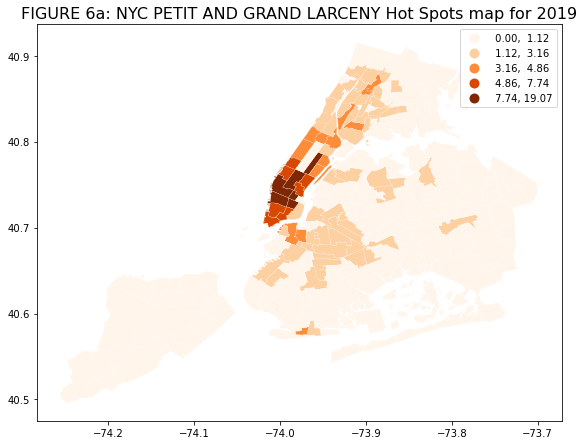

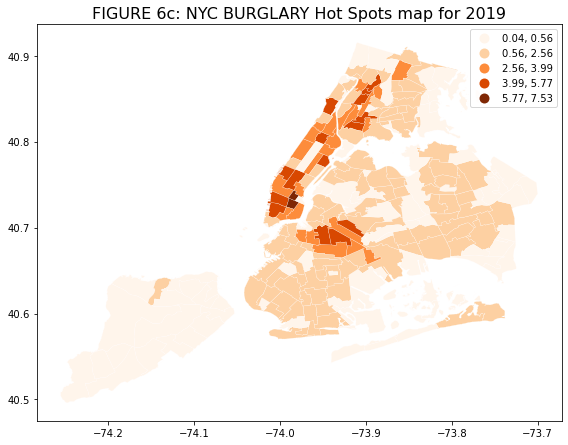

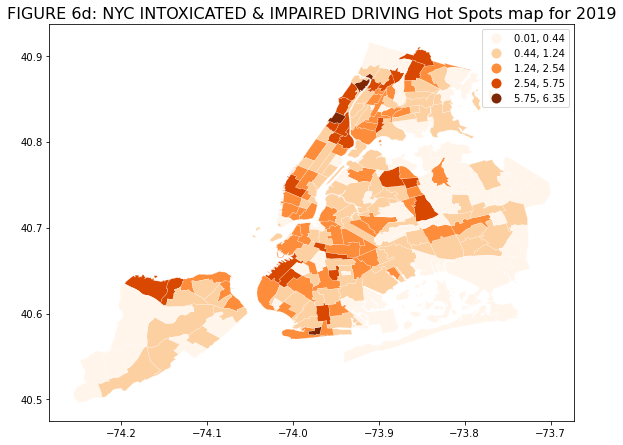

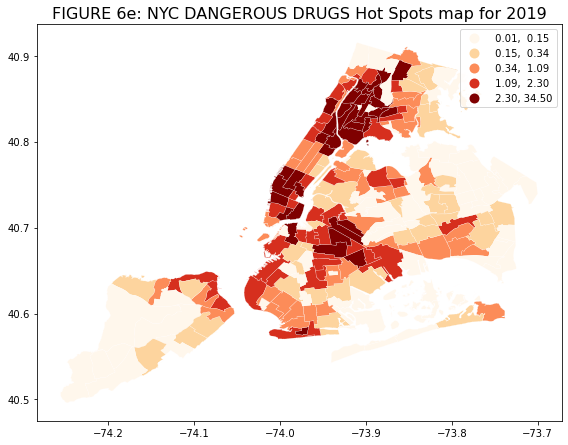

In [9]:
df_all_cns_count['geometry'] = df_all_cns_count['the_geom'].apply(wkt.loads)
df_all_cns_geo = gpd.GeoDataFrame(df_all_cns_count, geometry='geometry')

scheme1 = mapclassify.Quantiles(df_all_cns_geo['PAI'], k=5)

ofns_list = ['PETIT LARCENY', 'GRAND LARCENY']
# df_all_sel = df_all[df_all['OFNS_DESC'].isin(ofns_list) ]

 
fig = df_all_cns_geo[df_all_cns_geo['OFNS_DESC'].isin(ofns_list)].plot(column='PAI', cmap='Oranges',legend=True, scheme='fisher_jenks_sampled', edgecolor='white', figsize=[8,8], linewidth=0.2)  # scheme='quantiles'
plt.title('FIGURE 6a: NYC PETIT AND GRAND LARCENY Hot Spots map for 2019', fontsize=16)
plt.tight_layout()

df_all_cns_geo[df_all_cns_geo['OFNS_DESC'] == 'BURGLARY'].plot(column='PAI', cmap='Oranges', legend=True, scheme='fisher_jenks_sampled', edgecolor='white', figsize=[8,8] ,linewidth=0.2)
plt.title('FIGURE 6c: NYC BURGLARY Hot Spots map for 2019', fontsize=16)
plt.tight_layout()

df_all_cns_geo[df_all_cns_geo['OFNS_DESC'] == 'INTOXICATED & IMPAIRED DRIVING'].plot(column='PAI', cmap='Oranges', scheme='fisher_jenks_sampled', figsize=[8,8],legend=True, edgecolor='white' ,linewidth=0.2)
plt.title('FIGURE 6d: NYC INTOXICATED & IMPAIRED DRIVING Hot Spots map for 2019', fontsize=16)
plt.tight_layout()

df_all_cns_geo[df_all_cns_geo['OFNS_DESC'] == 'DANGEROUS DRUGS'].plot(column='PAI', cmap='OrRd', legend=True, edgecolor='white' ,linewidth=0.2, figsize=[8,8], scheme='quantiles')
plt.title('FIGURE 6e: NYC DANGEROUS DRUGS Hot Spots map for 2019', fontsize=16)
plt.tight_layout()

## Print top 5 hotspots for each crime type

In [10]:
top_places = df_all_cns_count[df_all_cns_count['OFNS_DESC'] == 'GRAND LARCENY'].sort_values(by=['PAI'], ascending=False) \
    [['Borough_x', 'NTA Name_x' , 'PAI','counts']].head(5)
print('\n Hot Crime Spots for GRAND LARCENY')
print(top_places)

top_places = df_all_cns_count[df_all_cns_count['OFNS_DESC'] == 'PETIT LARCENY'].sort_values(by=['PAI'], ascending=False) \
    [['Borough_x', 'NTA Name_x' , 'PAI','counts']].head(5)
print('\n Hot Crime Spots for PETIT LARCENY')
print(top_places)

top_places = df_all_cns_count[df_all_cns_count['OFNS_DESC'] == 'BURGLARY'].sort_values(by=['PAI'], ascending=False) \
    [['Borough_x', 'NTA Name_x' , 'PAI','counts']].head(5)
print('\n Hot Crime Spots for BURGLARY')
print(top_places)

top_places = df_all_cns_count[df_all_cns_count['OFNS_DESC'] == 'INTOXICATED & IMPAIRED DRIVING'].sort_values(by=['PAI'], ascending=False) \
    [['Borough_x', 'NTA Name_x' , 'PAI','counts']].head(5)
print('\n Hot Crime Spots for INTOXICATED & IMPAIRED DRIVING')
print(top_places)

top_places = df_all_cns_count[df_all_cns_count['OFNS_DESC'] == 'DANGEROUS DRUGS'].sort_values(by=['PAI'], ascending=False) \
    [['Borough_x', 'NTA Name_x' , 'PAI','counts']].head(5)
print('\n Hot Crime Spots for DANGEROUS DRUGS')
print(top_places)


 Hot Crime Spots for GRAND LARCENY
     Borough_x                                   NTA Name_x        PAI  counts
1    Manhattan                        Midtown-Midtown South  19.067666    2737
231  Manhattan                                     Gramercy  10.590831     379
161  Manhattan                                 East Village   9.325197     483
6    Manhattan  Hudson Yards-Chelsea-Flat Iron-Union Square   9.033319    1592
26   Manhattan                Upper East Side-Carnegie Hill   8.972937     856

 Hot Crime Spots for PETIT LARCENY
     Borough_x                                   NTA Name_x        PAI  counts
0    Manhattan                        Midtown-Midtown South  12.146383    3762
40   Manhattan                               Lincoln Square   7.832609    1270
230  Manhattan                                     Gramercy   7.744573     598
60   Manhattan                         Central Harlem South   7.675869    1137
5    Manhattan  Hudson Yards-Chelsea-Flat Iron-Union Square